In [1]:
# import ...
import csv
import gensim
import matplotlib.pyplot as plot
import matplotlib.cm as cm
import nltk
import numpy as np
import re

# from...
# python standard libraries
from pathlib import Path
from collections import defaultdict, OrderedDict

# from...
# third party packages
from gensim import corpora, models
from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from sklearn.manifold import TSNE

# nltk.download('book')
# nltk.download('brown')
np.random.seed(2018)
CROWD_RE_REQUIREMENTS = Path('..', 'crowdre_cleaned-csv', 'requirements.csv')

In [2]:
class Requirement(object):
    def __init__(self, text, tags):
        self.text = text
        self.cleaned_text = re.sub(r"[^a-zA-Z\s]","", text)
        self.tags = tags.split(",")
        self.cleaned_tags = self.clean_tags(self.tags)
    
    def tokenize(self):
        self.tokens = nltk.word_tokenize(self.cleaned_text)
    
    def check_redundancy(self):
        self.contains_redundancy = "i want my smart home to" in self.text.lower()
    
    def remove_stopwords(self):
        self.lexical_words = [word for word in self.tokens if word not in stopwords.words('english')]
        
    def reduce_to_stem(self):
        #lancasterStemmer = LancasterStemmer()
        porterStemmer = PorterStemmer()
        self.stems = []
        for lexicalWord in self.lexical_words:
            self.stems.append(porterStemmer.stem(lexicalWord))
                
    def clean_tags(self, tags):
        whitespace_filter = lambda t: t != " " and t != ""
        whitespace_strip = lambda t: t.strip()
        cleaned_tags = list(map(whitespace_strip, filter(whitespace_filter, tags)))
        return cleaned_tags
        
    def complete_analysis(self):
        self.tokenize()
        self.check_redundancy()
        self.remove_stopwords()
        self.reduce_to_stem()
    
    def __str__(self):
        return self.text

In [3]:
class CrowdREReader(object):
    def __init__(self, path):
        if not path.exists() and path.is_file():
            raise("The given path does not exist or is not a file.")
        self.csv = path
        self.requirements = []
        
    def read(self):
        with open(self.csv, newline='') as requirements_csv:
            re_reader = csv.DictReader(requirements_csv, delimiter=',')
            for row in re_reader:
                requirement = self._read_row(row)
                self.requirements.append(requirement)
    
    def _read_row(self, row):
        role = row['role']
        feature = row['feature']
        benefit = row['benefit']
        tags = row['tags']
        
        requirement_text = self._build_requirement_text(role, feature, benefit)
        return Requirement(requirement_text, tags)

    def _build_requirement_text(self, role, feature, benefit):
            requirementText = "As a {role} I want {feature} so that {benefit}".format(
                role=role, feature=feature, benefit=benefit
            )
            return requirementText

In [4]:
crowdre_reader = CrowdREReader(CROWD_RE_REQUIREMENTS)
crowdre_reader.read()

In [5]:
# NLP analysis
joined_text = " ".join(map(lambda re: re.text, crowdre_reader.requirements))
joined_text_tokenized = nltk.word_tokenize(joined_text)

no_of_requirements = len(crowdre_reader.requirements)
tokens = []
lexical_words = []
stems = []
requirements_with_redundancy = 0

for requirement in crowdre_reader.requirements:
    requirement.complete_analysis()
    tokens += requirement.tokens    
    lexical_words += requirement.lexical_words
    stems += requirement.stems
    if requirement.contains_redundancy:
        requirements_with_redundancy += 1 

In [6]:
print("Number of Tokens (unique): \t\t{} ({})".format(len(tokens), len(set(tokens))))
print("Number of Lexical Words: \t\t{}".format(len(lexical_words)))

print("\nVocabulary Size (Lexical Words): \t{}".format(len(set(lexical_words))))
print("Vocabulary Size (Stems): \t\t{}".format(len(set(stems))))

print("\nAverage Sentence Length (Tokens): \t{}".format(round(len(tokens) / no_of_requirements)))
print("Average Sentence Length (Lexical Words):{}".format(round(len(lexical_words) / no_of_requirements)))

print("\nLexical Diversity: \t\t\t{}".format(round(len(set(lexical_words)) / len(joined_text),3)))
print("Requirements containing\n\t'...I want my smart home to...': \t{}/{} ({}%)".format(requirements_with_redundancy, no_of_requirements, round(requirements_with_redundancy / no_of_requirements * 100, 2)))


Number of Tokens (unique): 		87542 (4968)
Number of Lexical Words: 		49374

Vocabulary Size (Lexical Words): 	4851
Vocabulary Size (Stems): 		3242

Average Sentence Length (Tokens): 	30
Average Sentence Length (Lexical Words):17

Lexical Diversity: 			0.011
Requirements containing
	'...I want my smart home to...': 	416/2966 (14.03%)


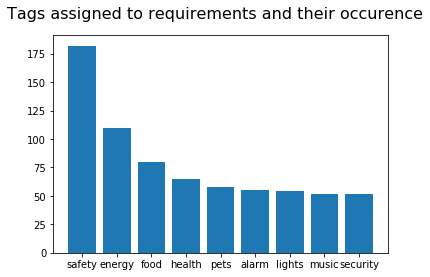

Total amount of tags: 5232
Requirements with tags: 2592 (87.39%)
Tags per Requirement: min: 0, avg: 1, max: 11


In [7]:
#analyze tags
tags = defaultdict(int)
tags_per_requirement = []
tagged_requirements = 0
for requirement in crowdre_reader.requirements:
    for tag in requirement.cleaned_tags:
        tags[tag] += 1
    tags_per_requirement.append(len(requirement.cleaned_tags))
    if len(requirement.cleaned_tags) > 0:
        tagged_requirements += 1

sorted_tags = OrderedDict(sorted(tags.items(), key=lambda t: t[1], reverse=True))

x = list(sorted_tags.keys())[:9]
y = list(sorted_tags.values())[:9]
plot.bar(x, y)
plot.suptitle("Tags assigned to requirements and their occurence", fontsize=16)
plot.show()
print("Total amount of tags: %d" % sum(tags_per_requirement))
print("Requirements with tags: {} ({}%)".format(tagged_requirements, round((tagged_requirements/len(crowdre_reader.requirements)*100),2)))
print("Tags per Requirement: min: %d, avg: %d, max: %d" % (min(tags_per_requirement), sum(tags_per_requirement)/len(tags_per_requirement), max(tags_per_requirement)))

In [8]:
# Prepare Dataset for LDA

stemsList = []
for requirement in crowdre_reader.requirements:
    stemsList.append(requirement.stems)

# Bag of Words on the Data set
dictionary = gensim.corpora.Dictionary(stemsList)

# Filter out:
# less than 15 documents (absolute number) or
# more than 0.5 documents (fraction of total corpus size, not absolute number).
# after the above two steps, keep only the first 100000 most frequent tokens.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Gensim doc2bow
bow_corpus = [dictionary.doc2bow(reqirement) for reqirement in stemsList]
bow_doc_2965 = bow_corpus[2965]

for i in range(len(bow_doc_2965)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2965[i][0], 
                                               dictionary[bow_doc_2965[i][0]], 
bow_doc_2965[i][1]))

Word 14 ("hous") appears 1 time.
Word 16 ("occup") appears 1 time.
Word 79 ("time") appears 1 time.
Word 129 ("notifi") appears 1 time.
Word 165 ("potenti") appears 1 time.
Word 212 ("avoid") appears 1 time.
Word 220 ("without") appears 1 time.
Word 225 ("enjoy") appears 1 time.


In [9]:
# Running LDA using Bag of Words
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)
# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWords: {}\n'.format(idx, topic))

Topic: 0
Words: 0.040*"door" + 0.035*"owner" + 0.028*"smart" + 0.027*"know" + 0.024*"parent" + 0.019*"lock" + 0.019*"person" + 0.018*"hous" + 0.016*"open" + 0.016*"child"

Topic: 1
Words: 0.046*"occup" + 0.036*"smart" + 0.033*"music" + 0.025*"hous" + 0.025*"turn" + 0.025*"time" + 0.018*"light" + 0.015*"room" + 0.015*"get" + 0.014*"alarm"

Topic: 2
Words: 0.051*"owner" + 0.032*"smart" + 0.030*"alert" + 0.023*"hous" + 0.022*"occup" + 0.022*"time" + 0.020*"pet" + 0.016*"dont" + 0.016*"cat" + 0.016*"safe"

Topic: 3
Words: 0.039*"occup" + 0.032*"get" + 0.030*"automat" + 0.028*"parent" + 0.024*"room" + 0.021*"turn" + 0.021*"time" + 0.020*"owner" + 0.018*"light" + 0.016*"music"

Topic: 4
Words: 0.061*"occup" + 0.042*"water" + 0.032*"know" + 0.028*"smart" + 0.018*"save" + 0.017*"energi" + 0.016*"parent" + 0.015*"clean" + 0.014*"use" + 0.014*"owner"

Topic: 5
Words: 0.029*"smart" + 0.025*"occup" + 0.024*"cook" + 0.023*"time" + 0.021*"owner" + 0.018*"alert" + 0.017*"dont" + 0.017*"parent" + 0.01

In [10]:
# TF-IDF
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# Running LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(idx, topic))

Topic: 0
Word: 0.016*"turn" + 0.016*"water" + 0.014*"owner" + 0.013*"energi" + 0.012*"save" + 0.012*"light" + 0.012*"room" + 0.012*"time" + 0.011*"occup" + 0.010*"alert"

Topic: 1
Word: 0.020*"light" + 0.018*"save" + 0.018*"pet" + 0.017*"alert" + 0.017*"room" + 0.016*"energi" + 0.016*"owner" + 0.014*"turn" + 0.013*"hous" + 0.012*"occup"

Topic: 2
Word: 0.018*"occup" + 0.017*"electr" + 0.015*"water" + 0.015*"save" + 0.014*"smart" + 0.014*"plant" + 0.013*"owner" + 0.013*"get" + 0.012*"room" + 0.012*"bill"

Topic: 3
Word: 0.016*"hous" + 0.015*"get" + 0.014*"water" + 0.014*"occup" + 0.012*"smart" + 0.012*"parent" + 0.011*"know" + 0.011*"leav" + 0.011*"let" + 0.011*"dont"

Topic: 4
Word: 0.016*"occup" + 0.015*"clean" + 0.014*"hous" + 0.013*"dont" + 0.013*"door" + 0.013*"wake" + 0.013*"owner" + 0.012*"automat" + 0.011*"leav" + 0.010*"game"

Topic: 5
Word: 0.029*"clean" + 0.018*"automat" + 0.017*"occup" + 0.015*"time" + 0.014*"safe" + 0.013*"hous" + 0.013*"save" + 0.012*"owner" + 0.012*"smart

In [21]:
re_sentences = list(map(lambda re: re.tokens, crowdre_reader.requirements))
model = gensim.models.Word2Vec(re_sentences, min_count=5, size=50)

In [22]:
model.wv.words_closer_than("owner", "want")

['a', 'As', 'home', 'occupant', 'smart', 'parent', 'pet']

In [26]:
keys = ["child", "pet", "water", "light", "temperature"]

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [27]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

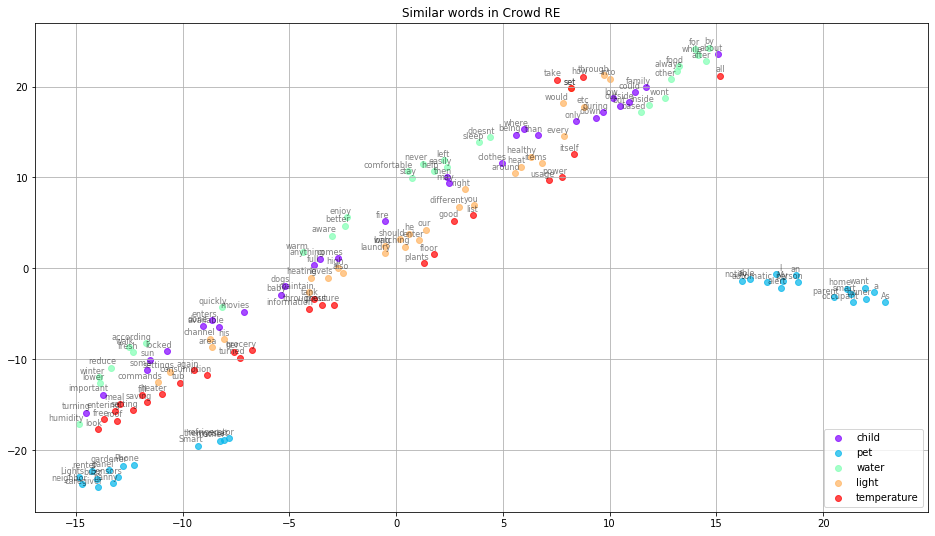

In [28]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plot.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plot.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plot.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plot.legend(loc=4)
    plot.title(title)
    plot.grid(True)
    if filename:
        plot.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plot.show()


tsne_plot_similar_words('Similar words in Crowd RE', keys, embeddings_en_2d, word_clusters, 0.7, 'crowdre_similar_words.png')